In [1]:
import pandas as pd

In [2]:
issues = pd.read_csv('clusters.csv')
issues.head()

,Cluster Name,Review ID,Issue
0,Durability Issues,0,Die geklebte Folie löst sich ab
1,Durability Issues,2,Es war nach wenigen Minuten kaputt
2,Durability Issues,4,am nächsten Tag schon gerissen
3,Durability Issues,8,nicht stabil
4,Durability Issues,8,ziemlich schnell hinüber


In [3]:
from pathlib import Path


review_paths = list(Path('ReviewFetcher/raw_reviews').glob('*.txt'))

In [4]:
import json
from utils import parse_to_date_object

dates = []


for review_path in review_paths:
    review_id = int(review_path.stem[7:])
    review = json.loads(review_path.read_text().replace('"', '\\"').replace("'", '"'))
    date = parse_to_date_object(review['date'])

    dates.append([review_id, date])

dates_df = pd.DataFrame(dates, columns=['Review ID', 'date'])
data = pd.merge(issues, dates_df, on='Review ID')

In [5]:
data.head()

,Cluster Name,Review ID,Issue,date
0,Durability Issues,0,Die geklebte Folie löst sich ab,2024-05-25
1,Durability Issues,2,Es war nach wenigen Minuten kaputt,2024-05-05
2,Durability Issues,4,am nächsten Tag schon gerissen,2024-04-10
3,Durability Issues,8,nicht stabil,2024-03-21
4,Durability Issues,8,ziemlich schnell hinüber,2024-03-21


In [9]:
data.to_csv('clusters_with_dates.csv', index=False)

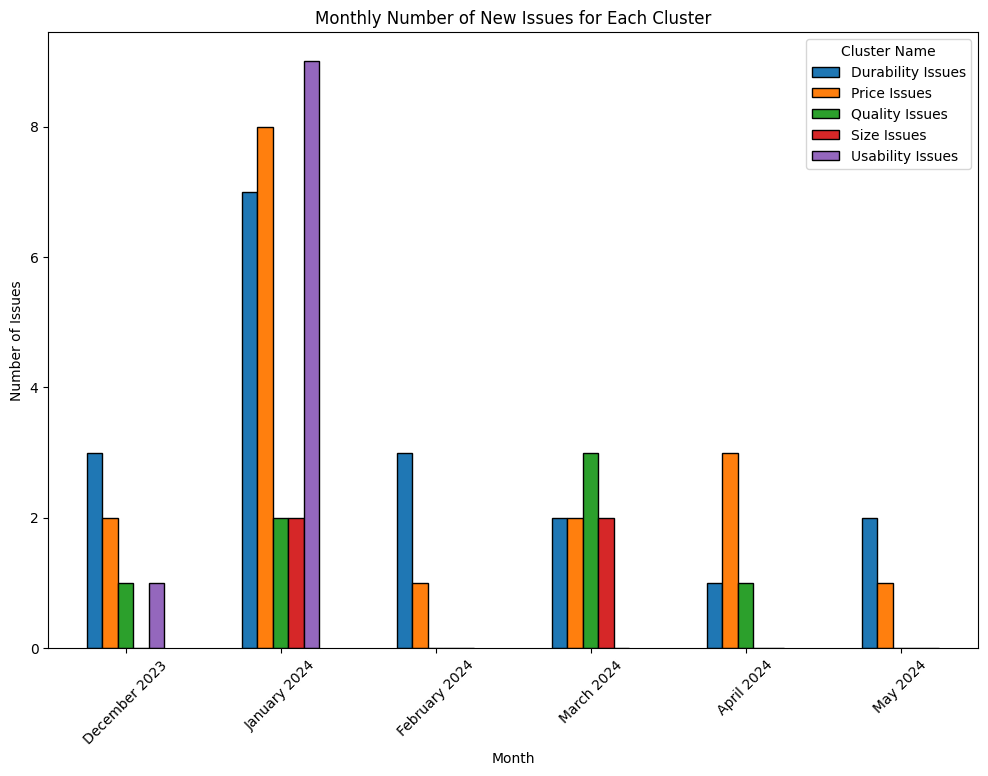

In [6]:
import matplotlib.pyplot as plt
import locale

data = pd.merge(issues, dates_df, on='Review ID')

# Set locale to English
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Set 'date' as the index
data.set_index('date', inplace=True)

# Resample to monthly frequency and count the number of issues
monthly_issues = data.groupby('Cluster Name').resample('ME').size().unstack(fill_value=0)

# Plot the monthly number of new issues for each cluster
fig, ax = plt.subplots(figsize=(12, 8))
monthly_issues.T.plot(kind='bar', ax=ax, edgecolor='black')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Issues')
ax.set_title('Monthly Number of New Issues for Each Cluster')

# Set x-ticks to be month names
ax.set_xticks(range(len(monthly_issues.columns)))
ax.set_xticklabels([date.strftime('%B %Y') for date in monthly_issues.columns], rotation=45)

ax.legend(title='Cluster Name')
plt.show()


# Dynamic

In [10]:
import pandas as pd
import plotly.express as px
import locale

# Set locale to English
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

# Sample data
data = pd.merge(issues, dates_df, on='Review ID')

# Convert 'date' column to datetime if not already
data['date'] = pd.to_datetime(data['date'])

# Resample to monthly frequency and count the number of issues
monthly_issues = data.groupby(['Cluster Name', pd.Grouper(key='date', freq='ME')]).size().reset_index(name='Issue Count')

# Create a string for the hover data combining issue descriptions
data['hover_text'] = data['Issue'] + " (" + data['date'].dt.strftime('%d.%m.%y') + ")"
hover_text_df = data.groupby(['Cluster Name', pd.Grouper(key='date', freq='ME')])['hover_text'].apply(lambda x: '<br>'.join(x)).reset_index()

# Merge hover_text back to monthly_issues
monthly_issues = monthly_issues.merge(hover_text_df, on=['date', 'Cluster Name'], how='left')

# Plot using plotly
fig = px.bar(monthly_issues, x='date', y='Issue Count', color='Cluster Name', barmode='group',
             custom_data=['hover_text'],
             title='Monthly Number of New Issues for Each Cluster')

# Update hover template to show issues only
fig.update_traces(hovertemplate='%{customdata}')

fig.update_layout(xaxis_title='Month', yaxis_title='Number of Issues',  width=1000,  # Set the width of the plot
    bargap=0.1)   # Set the gap between bars (0 to 1, where 0 is no gap and 1 is full gap))

fig.write_html("plot.html")


fig.show()